In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
%matplotlib inline
#%matplotlib notebook
plt.style.use('ggplot')

In [122]:
pd.set_option('display.max_columns', None)

#reads in each csv separately
pitches = pd.read_csv('../data/pitches.csv', low_memory=False)

In [123]:
#finds all nans and uses np.where to grab axis [0] grabs first of tuple
rows_with_nans = np.where(pitches.isna().any(axis=1) == True)[0]

#new df with dropped nans, inplace=True
pitches.drop(index=rows_with_nans, axis=0, inplace=True)
pitches.reset_index(inplace=True)
#finds 'UN' in pitches and drops those rows
UN_mask = np.where(pitches['pitch_type'] == 'UN')[0]
#drops the rows using the indicies from above
pitches.drop(UN_mask, inplace=True)
#gets rid of po because it is the same as fo
pitches['pitch_type'].replace('PO', 'FO', inplace=True)

In [124]:
#in order to get a better picture lets merge atbats with pitches to see the different pictures
game_sit = pd.merge(atbats, pitches[['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir', 'break_angle', 'break_length', 'code', 'type', 'pitch_type', 'b_score', 'b_count', 's_count', 'outs', 'pitch_num', 'on_1b', 'on_2b', 'on_3b', 'ab_id']], on='ab_id')

#creates full name column inside names df
names['full_name'] = names['first_name'] + ' ' + names['last_name']
#merges names with game situation df 
merged_names = pd.merge(names[['full_name', 'id']], game_sit, left_on='id', right_on='batter_id')
#merges the above merged names with the pitcher id now
final_play_df = pd.merge(merged_names, names[['full_name', 'id']], left_on='pitcher_id', right_on='id')
#renames some of the merged column names, and drops other id_x and id+y columns
final_play_df = final_play_df.rename(columns={'full_name_x':'batter_name', 'g_id':'game_id', 'o' :'post_outs', 'stand':'batter_stand', 'full_name_y':'pitcher_name'}).drop(columns=['id_x', 'id_y'])

In [125]:
atbats = pd.read_csv('../data/atbats.csv', low_memory=False)

games = pd.read_csv('../data/games.csv', low_memory=False)

names = pd.read_csv('../data/player_names.csv', low_memory=False)

In [126]:
final_play_df

,batter_name,ab_id,batter_id,event,game_id,inning,post_outs,p_score,p_throws,pitcher_id,batter_stand,top,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,code,type,pitch_type,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,pitcher_name
0,Jon Lester,2015000019,452657,Strikeout,201500001,2,3,2,R,425794,L,False,0.380000,2.801000,86.7,79.7,1701.467,163.563,-14.4,4.9,C,S,FC,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,Adam Wainwright
1,Jon Lester,2015000019,452657,Strikeout,201500001,2,3,2,R,425794,L,False,-0.126000,3.072000,86.3,80.1,1105.252,165.136,-7.0,5.9,F,S,FC,0.0,0.0,1.0,2.0,2.0,0.0,0.0,1.0,Adam Wainwright
2,Jon Lester,2015000019,452657,Strikeout,201500001,2,3,2,R,425794,L,False,-0.317000,2.771000,89.7,82.9,1371.679,177.918,-2.2,4.8,C,S,FF,0.0,0.0,2.0,2.0,3.0,0.0,0.0,1.0,Adam Wainwright
3,Jon Lester,2017111163,452657,Groundout,201701451,3,1,0,R,425794,L,False,-0.678799,3.506522,83.0,76.6,750.038,193.928,2.4,7.1,C,S,FC,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Adam Wainwright
4,Jon Lester,2017111163,452657,Groundout,201701451,3,1,0,R,425794,L,False,0.613893,2.333911,69.1,63.4,1275.752,46.741,-10.0,15.5,C,S,CU,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,Adam Wainwright
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847188,Bradley Zimmer,2017160269,605548,Flyout,201702093,9,1,2,R,542963,L,True,0.287496,3.338040,69.1,63.8,1866.236,199.688,10.7,8.1,X,X,CU,10.0,2.0,1.0,0.0,4.0,0.0,0.0,0.0,Rob Brantly
2847189,Greg Allen,2017160272,656185,Groundout,201702093,9,3,2,R,542963,L,True,0.438814,1.807681,61.7,57.6,1677.148,199.382,7.7,11.2,C,S,CU,11.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,Rob Brantly
2847190,Greg Allen,2017160272,656185,Groundout,201702093,9,3,2,R,542963,L,True,0.225578,5.626810,52.7,48.4,1122.096,195.154,2.9,17.7,B,B,CU,11.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,Rob Brantly
2847191,Greg Allen,2017160272,656185,Groundout,201702093,9,3,2,R,542963,L,True,-0.869203,5.081985,67.6,62.0,1618.366,194.065,6.6,8.7,B,B,CU,11.0,1.0,1.0,2.0,3.0,0.0,0.0,0.0,Rob Brantly


In [127]:
#grabs columns that make sense
final_play_df = final_play_df[['pitcher_name', 'batter_name', 'ab_id', 'batter_id', 'pitcher_id', 'game_id', 'inning', 'p_score', 'p_throws', 'batter_stand', 'top', 'b_score', 'b_count', 's_count', 'outs', 'pitch_num', 'on_1b', 'on_2b', 'on_3b', 'pitch_type']]
#replaces R and L with 1's and 0's
final_play_df.replace({'R': 1, 'L': 0}, inplace=True)

/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [128]:
final_play_df

,pitcher_name,batter_name,ab_id,batter_id,pitcher_id,game_id,inning,p_score,p_throws,batter_stand,top,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,pitch_type
0,Adam Wainwright,Jon Lester,2015000019,452657,425794,201500001,2,2,1,0,False,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,FC
1,Adam Wainwright,Jon Lester,2015000019,452657,425794,201500001,2,2,1,0,False,0.0,0.0,1.0,2.0,2.0,0.0,0.0,1.0,FC
2,Adam Wainwright,Jon Lester,2015000019,452657,425794,201500001,2,2,1,0,False,0.0,0.0,2.0,2.0,3.0,0.0,0.0,1.0,FF
3,Adam Wainwright,Jon Lester,2017111163,452657,425794,201701451,3,0,1,0,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,FC
4,Adam Wainwright,Jon Lester,2017111163,452657,425794,201701451,3,0,1,0,False,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,CU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847188,Rob Brantly,Bradley Zimmer,2017160269,605548,542963,201702093,9,2,1,0,True,10.0,2.0,1.0,0.0,4.0,0.0,0.0,0.0,CU
2847189,Rob Brantly,Greg Allen,2017160272,656185,542963,201702093,9,2,1,0,True,11.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,CU
2847190,Rob Brantly,Greg Allen,2017160272,656185,542963,201702093,9,2,1,0,True,11.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,CU
2847191,Rob Brantly,Greg Allen,2017160272,656185,542963,201702093,9,2,1,0,True,11.0,1.0,1.0,2.0,3.0,0.0,0.0,0.0,CU


## Future Directions

Using each at bat to predict the outcome of the at bat? Using LSTM to know what the count is (how many balls and strikes), to use how many pitches the pitcher has thrown, to use what pitch types he has thrown, to use the handedness of the batter and pitcher, using the score of the game.. So on...

Or using Linear Regression to see how many pitches the pitcher can withstand? Using some sort of metric about the number of hits/runs they give up to know how many pitches thrown is too many. 

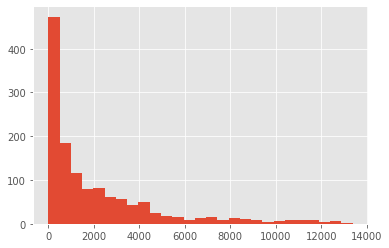

In [129]:
#how many pitches has each pitcher thrown? 
final_play_df.groupby('pitcher_name').count().sort_values('batter_name', ascending=False).iloc[:, 0].hist(bins='fd')

In [130]:
final_play_df

,pitcher_name,batter_name,ab_id,batter_id,pitcher_id,game_id,inning,p_score,p_throws,batter_stand,top,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,pitch_type
0,Adam Wainwright,Jon Lester,2015000019,452657,425794,201500001,2,2,1,0,False,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,FC
1,Adam Wainwright,Jon Lester,2015000019,452657,425794,201500001,2,2,1,0,False,0.0,0.0,1.0,2.0,2.0,0.0,0.0,1.0,FC
2,Adam Wainwright,Jon Lester,2015000019,452657,425794,201500001,2,2,1,0,False,0.0,0.0,2.0,2.0,3.0,0.0,0.0,1.0,FF
3,Adam Wainwright,Jon Lester,2017111163,452657,425794,201701451,3,0,1,0,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,FC
4,Adam Wainwright,Jon Lester,2017111163,452657,425794,201701451,3,0,1,0,False,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,CU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847188,Rob Brantly,Bradley Zimmer,2017160269,605548,542963,201702093,9,2,1,0,True,10.0,2.0,1.0,0.0,4.0,0.0,0.0,0.0,CU
2847189,Rob Brantly,Greg Allen,2017160272,656185,542963,201702093,9,2,1,0,True,11.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,CU
2847190,Rob Brantly,Greg Allen,2017160272,656185,542963,201702093,9,2,1,0,True,11.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,CU
2847191,Rob Brantly,Greg Allen,2017160272,656185,542963,201702093,9,2,1,0,True,11.0,1.0,1.0,2.0,3.0,0.0,0.0,0.0,CU


In [131]:
pitchers_top500 = final_play_df.groupby('pitcher_name').count().sort_values('batter_name', ascending=False).iloc[:500, 0].index
pitchers_top500

Index(['Max Scherzer', 'Justin Verlander', 'Chris Archer', 'Jose Quintana',
       'Rick Porcello', 'Chris Sale', 'Jon Lester', 'Corey Kluber',
       'Gio Gonzalez', 'Zack Greinke',
       ...
       'Jason Motte', 'Juan Minaya', 'Frankie Montas', 'Kevin McCarthy',
       'Julio Urias', 'Brett Oberholtzer', 'James Pazos', 'Dereck Rodriguez',
       'Warwick Saupold', 'Drew Steckenrider'],
      dtype='object', name='pitcher_name', length=500)

In [142]:
df_500 = final_play_df[final_play_df['pitcher_name'].isin(pitchers_top500)]

Text(0.5, 0, 'Pitch Types')

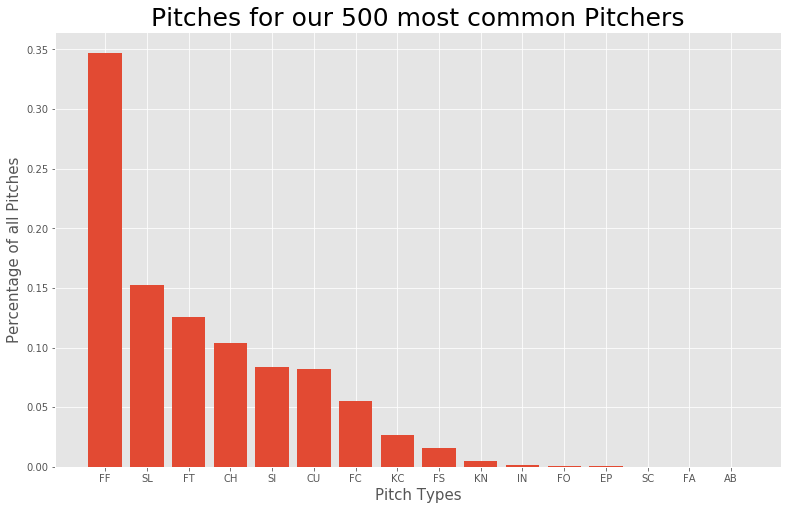

In [143]:
values = df.groupby('pitch_type').count().sort_values('pitcher_name', ascending=False).iloc[:, 0].values
index = df.groupby('pitch_type').count().sort_values('pitcher_name', ascending=False).iloc[:, 0].index
plt.figure(figsize=(13, 8))
plt.bar(index, values/np.sum(values))
plt.title('Pitches for our 500 most common Pitchers', size=25)
plt.ylabel('Percentage of all Pitches', size=15)
plt.xlabel('Pitch Types', size=15)

In [144]:
df_500

,pitcher_name,batter_name,ab_id,batter_id,pitcher_id,game_id,inning,p_score,p_throws,batter_stand,top,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,pitch_type
0,Adam Wainwright,Jon Lester,2015000019,452657,425794,201500001,2,2,1,0,False,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,FC
1,Adam Wainwright,Jon Lester,2015000019,452657,425794,201500001,2,2,1,0,False,0.0,0.0,1.0,2.0,2.0,0.0,0.0,1.0,FC
2,Adam Wainwright,Jon Lester,2015000019,452657,425794,201500001,2,2,1,0,False,0.0,0.0,2.0,2.0,3.0,0.0,0.0,1.0,FF
3,Adam Wainwright,Jon Lester,2017111163,452657,425794,201701451,3,0,1,0,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,FC
4,Adam Wainwright,Jon Lester,2017111163,452657,425794,201701451,3,0,1,0,False,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,CU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2812319,Edwin Diaz,Cedric Mullins,2018159304,656775,621242,201802085,9,5,1,0,True,2.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,FF
2812320,Edwin Diaz,Cedric Mullins,2018159304,656775,621242,201802085,9,5,1,0,True,2.0,2.0,1.0,0.0,4.0,0.0,0.0,0.0,FF
2812321,Edwin Diaz,Cedric Mullins,2018159304,656775,621242,201802085,9,5,1,0,True,2.0,3.0,1.0,0.0,5.0,0.0,0.0,0.0,FF
2812322,Edwin Diaz,Cedric Mullins,2018159304,656775,621242,201802085,9,5,1,0,True,2.0,3.0,2.0,0.0,6.0,0.0,0.0,0.0,FF
